## Spectral Analysis using Machine Learning
In this notebook, you will learn how to use machine learning to help us study the spectra of galaxies. The first section, which is filled in for you, will read your data and show you what it looks like. It's up to you to determine how you will extract the fluxes from the data!

### Problem description
In this problem we will explore the use of convolutional neural network to extract key spectral parameters directly from spectra without using additional fitting algorithms. While extremely useful, standard fitting algorithms used to extract data from spectra are plagued by issues such as convergence of the fits and efficacy in low signal  to noise regimes. Recent literature has shown the usefulness of machine learning algorithms to tackle both of these pitfalls.
 In this problem, students will be developing their own traditional artificial neural networks and convolutional neural networks to extract line fluxes from prominent emission lines in mock galaxy spectra. The students are suggested to start with the SN3 filter containing 5 prominent emission lines (Halpha, NII-doublet, and SII-doublet) since the SN3 filter has the strongest signal to noise and potential blending of components.

Line fluxes (and their ratios) are extremely helpful to astronomers since they teach us a considerable amount of information about the source ionizing the gas. Traditionally, we use [Baldwin, Phillips & Terlevich](https://sdss-marvin.readthedocs.io/en/latest/tools/bpt.html), or BPT, diagrams to differentiate between different ionization mechanisms. These diagrams require line ratios coming from the SN3, SN2, and SN1 filters -- it was no coincidence that these are the primary filters.

### Milestones estimators
1. Set up a standard neural network to extract the line ratios from the SN3  filter.
2. Set up a convolutional neural network to do the same and compare the results.
3. Modify the network structures to analyze the three filters simultaneously.
4. Explore data engineering algorithms to enhance estimates.
5. Modify the networks to calculate the fluxes directly instead of line ratios.

### Useful references
- https://arxiv.org/abs/1709.09182
- https://arxiv.org/abs/2008.08093
- https://arxiv.org/abs/2102.06230
- https://arxiv.org/abs/2102.08414
- https://arxiv.org/abs/2207.05107

## Read data

The cell below loads the simulated spectra and true line fluxes for 50,000 simulated galaxies.

The spectra in different filters are contained in the three `spectra_SNX` lists. The wavenumbers at which the spectra are measured are contained in the three `spectra_axis_SNX` lists.

`fluxes` contains the true fluxes for each galaxy at energies corresponding to different spectral lines (e.g. [H-alpha](https://en.wikipedia.org/wiki/H-alpha)). These are produced by electrons transitioning between different energies for various elements. The names of the lines and the wavelengths (in nanometers) are given in `line_dict` for reference.

The observed spectrum does not overlap perfectly with the true fluxes because the light from distant galaxies is redshifted, and the lines are broadened due to e.g. motion of the gas that's emitting. Additionally, the observations are noisy.

**Important note:** the lengths of the spectra and values at which they are measured are different for different galaxies! In other words, in general `len(spectra_axis_SNX[i]) != len(spectra_axis_SNX[j])` for different values of `i` and `j`.

In [ ]:
!pip install mplcyberpunk

import os

from google.colab import drive
import mplcyberpunk
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import trange


plt.style.use("cyberpunk")
drive.mount('/content/drive')
BASE_PATH = "drive/MyDrive/Astromatic2022-Data/Problems/Problem4"
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Spectra
spectra_SN3 = pickle.load(open(os.path.join(BASE_PATH, "spectrum_SN3.pkl"), "rb"))
spectra_SN2 = pickle.load(open(os.path.join(BASE_PATH, "spectrum_SN2.pkl"), "rb"))
spectra_SN1 = pickle.load(open(os.path.join(BASE_PATH, "spectrum_SN1.pkl"), "rb"))

# Values at which spectra are measured (in nm^-1)
# (The 1e-7 converts cm^-1 to nm^-1.)
spectra_axis_SN3 = [x / 1e7 for x in pickle.load(open(os.path.join(BASE_PATH, "spectrum_axis_SN3.pkl"), "rb"))]
spectra_axis_SN2 = [x / 1e7 for x in pickle.load(open(os.path.join(BASE_PATH, "spectrum_axis_SN2.pkl"), "rb"))]
spectra_axis_SN1 = [x / 1e7 for x in pickle.load(open(os.path.join(BASE_PATH, "spectrum_axis_SN1.pkl"), "rb"))]

# Labels
fluxes = [np.array(f) for f in pickle.load(open(os.path.join(BASE_PATH, "fluxes.pkl"), "rb"))]

# Names and wavelengths of emission lines (in nanometers) at corresponding to the elements
# in 'fluxes'
line_dict = {
    "Halpha": 656.28,
    "NII6548": 654.803,
    "NII6583": 658.341,
    "SII6716": 671.647,
    "SII6731": 673.085,
    "OIII5007": 500.684,
    "OIII4959": 495.891,
    "Hbeta": 486.133,
    "OII3726": 372.603,
    "OII3729": 372.882,
}

The cell below plots the spectra in different filters for a galaxy in blue. The true line fluxes are the pink dots, with the vertical dashed pink lines indicating their wavelengths.

Text(0.5, 0.98, 'Galaxy 0')

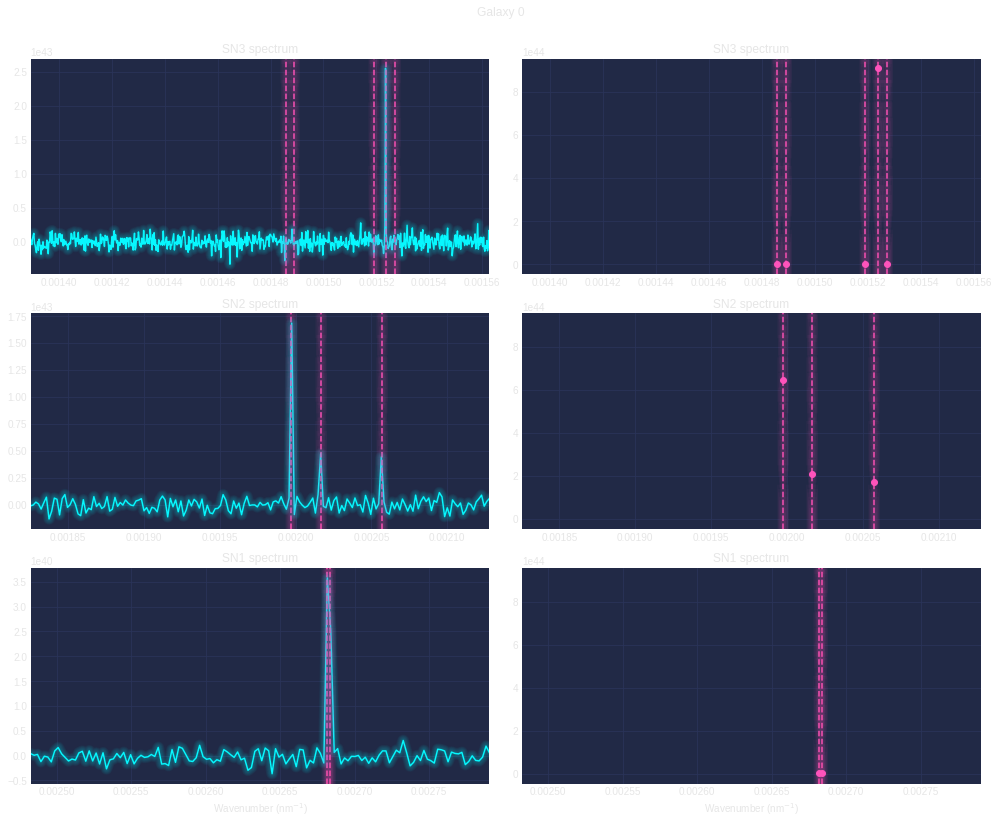

In [ ]:
idx = 0  # index of galaxy

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for ax, spec_ax, spec in zip(
    axes[:, 0],
    (spectra_axis_SN3[idx], spectra_axis_SN2[idx], spectra_axis_SN1[idx]),
    (spectra_SN3[idx], spectra_SN2[idx], spectra_SN1[idx]),
):
    ax.plot(spec_ax, spec)

# Plot true line fluxes
for ax in axes[:, 1]:    
    ax.scatter(
        1 / np.array(list(line_dict.values())),
        fluxes[idx],
        c="C1",
        label="Normalized true fluxes",
    )

# Indicate line energies
for ax in axes.flatten():
    for wvn in 1 / np.array(list(line_dict.values())):
        ax.axvline(wvn, color="C1", linestyle="--")
    mplcyberpunk.make_lines_glow(ax)

# Formatting
for ax in axes[0]:
    ax.set_xlim(spectra_axis_SN3[idx].min(), spectra_axis_SN3[idx].max())
    ax.set_title("SN3 spectrum")
for ax in axes[1]:
    ax.set_xlim(spectra_axis_SN2[idx].min(), spectra_axis_SN2[idx].max())
    ax.set_title("SN2 spectrum")
for ax in axes[2]:
    ax.set_xlim(spectra_axis_SN1[idx].min(), spectra_axis_SN1[idx].max())
    ax.set_title("SN1 spectrum")
for ax in axes[-1]:
    ax.set_xlabel(r"Wavenumber (nm$^{-1}$)")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(f"Galaxy {idx}")

## Learning from the spectra

Now that we have the data (50,000 spectra in three separate filters), we can start developing neural networks to extract the line ratios.

Some prompts to get you started:
- Can you predict the flux ratios between different lines? What about the actual values of the fluxes?
- How are you going to deal with the inconsistent axes and lengths of the spectra for different galaxies?
- Are there ways you can preprocess the data to make it easier to train neural networks?
- What network architecture makes sense here?

In [7]:
# TODO: define network
class Network(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, obs):
        ...

In [8]:
# Initialize network
network = Network()
network.to(DEVICE)  # put network on GPU

# Training loop
n_epochs = 1
for epoch in trange(n_epochs):  # progress bar
    # Training
    network.train()
    ...

    # Validation
    network.eval()
    with torch.no_grad():
        ...

  0%|          | 0/1 [00:00<?, ?it/s]